In [36]:
from src.utils_py.auxil import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Polygon
from scipy.spatial import Delaunay
from scipy.signal import convolve2d

In [383]:
grid = np.load(f'phase_diagrams/delta_0.1_grid.npy')
grid.shape

(100, 100)

In [384]:
filter1 = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
], dtype=int)
filter2 = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
], dtype=int)
filter3 = np.array([
    [0, 0, 0],
    [1, 0, 1],
    [0, 0, 0]
], dtype=int)
filter4 = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [0, 1, 0]
], dtype=int)

def get_border(grid, type):
    region = grid.copy()
    region[region!=type] = 0
    region[region==type] = 1
    region_conv1 = convolve2d(filter2, region)[1:-1, 1:-1]
    # region[np.logical_not(np.logical_and(region_conv>=3, region_conv<=5))] = 0
    region[region_conv1 > 3] = 0

    # region_conv2 = convolve2d(filter1, region)[1:-1, 1:-1]
    # region[np.logical_and(region_conv1 > 3, region_conv2>5)] = 0
    # region[region__conv>5] = 0

    return region

In [385]:
def get_region(grid, type):
    region = grid.copy()
    region[region!=type] = 0
    region[region==type] = 1

    return region

In [357]:
neigh_coords = np.argwhere(np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
], dtype=int))

def sort_xy(xy, border):
    N, M = border.shape
    sorted_xy = list()
    sorted_xy.append(xy[0, ::-1].tolist())

    i = 0
    # while i < xy.shape[0]-1:
    for i in range(xy.shape[0]-1):
        for j in range(neigh_coords.shape[0]):
            xj, yj = (np.array(sorted_xy[i-1][::-1], dtype=int) - 1) + neigh_coords[j, :]

            # Проверка выхода за границу
            if not (0 <= xj < N) or not (0 <= yj < M): continue

            # Проверка соседа
            if border[xj, yj]:
                # Проверка, что сосед уже в отсортированном массиве
                if i > 0:
                    # if np.all(sorted_xy[i-1, :] == [xj, yj]):
                    if [yj, xj] in sorted_xy:
                        continue

                sorted_xy.append([yj, xj])
                break

    return np.array(sorted_xy, dtype=int)


In [358]:
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [359]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

In [360]:
def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

In [379]:
type_id = 4

# border = get_border(grid, type_id)
border = get_region(grid, type_id)
xy = np.argwhere(border)
# xy = sort_xy(xy, border)
# poly = Polygon(xy, hatch='/')

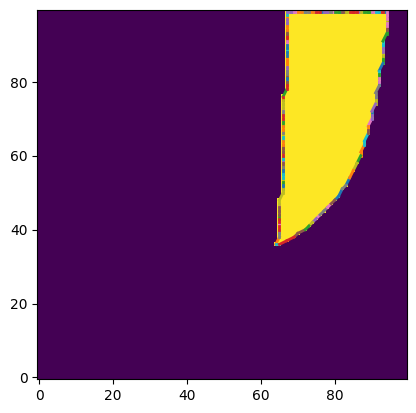

In [380]:
# Plotting the output
edges = alpha_shape(xy, 2)
polys = stitch_boundaries(edges)
plt.imshow(border, origin='lower')
# plt.plot(xy[:, 0], xy[:, 1], '.')
for i, j in edges:
    plt.plot(xy[[i, j], 1], xy[[i, j], 0], lw=2)
plt.show()

In [346]:
tri = Delaunay(xy, incremental=True)

In [283]:
edges = alpha_shape(xy, 4)

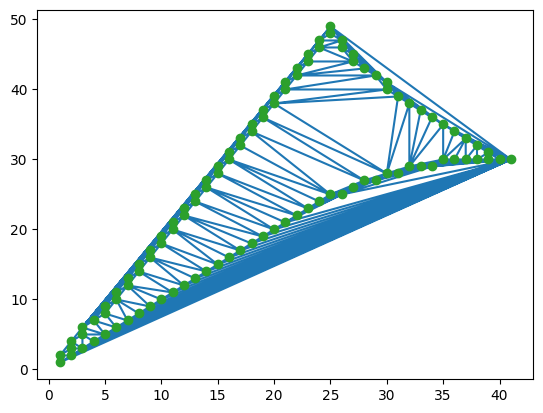

In [266]:
points = tri.points
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

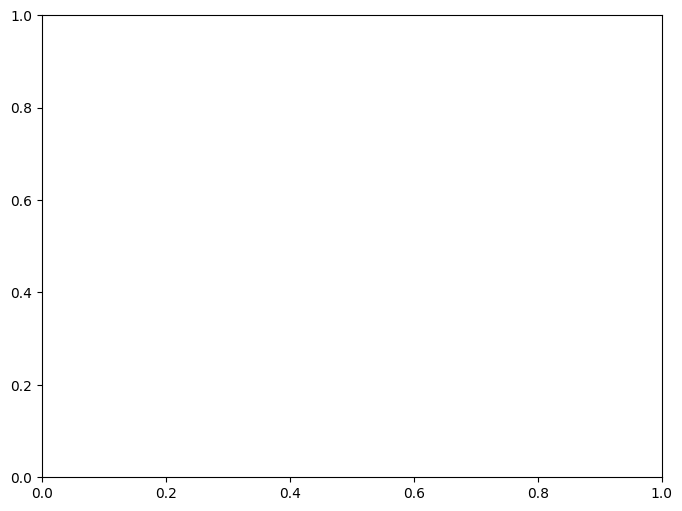

In [382]:
plt.figure(figsize=(8, 6))

# plt.imshow(grid)
# coords = np.argwhere(border)
# x_min, y_min = coords.min(axis=0)
# x_max, y_max = coords.max(axis=0)
# cropped = border[x_min:x_max+1, y_min:y_max+1]
# plt.imshow(cropped,  origin='lower')

ax = plt.gca()
# ax.imshow(border, origin='lower')

edges = alpha_shape(xy, 50)
polys = stitch_boundaries(edges)
for poly in polys:
    xy_ = list()
    xy_.append(xy[poly[0][0]].tolist())
    for pair in poly:
        xy_.append(xy[pair[1]].tolist())

    p = Polygon(np.array(xy_, dtype=int)[:, ::-1], hatch='')
    ax.add_patch(p)

plt.show()

In [249]:
simp = tri.simplices
inc = simp[0, :]
xy[inc, :]

array([[41, 30],
       [ 2,  2],
       [ 1,  1]])

In [ ]:
arr = np.zeros_like(border)
l = 225
for i in range(l):
    xi, yi = xy[i, :]
    arr[xi, yi] = 1

plt.figure(figsize=(8, 6))

# plt.imshow(grid)
plt.imshow(arr, origin='lower')
plt.show()

In [37]:
poly = Polygon(xy)

---
# Graham scan

In [424]:
from collections import deque
from functools import cmp_to_key

In [575]:
grid = np.load(f'phase_diagrams/delta_0.1_grid.npy')
grid.shape

(100, 100)

In [588]:
region = get_region(grid, 4)
points = np.argwhere(region).tolist()
stack = deque()

In [589]:
mn = points[0]

for i in range(1, len(points)):
    mni = points[i]

    if mni[0] < mn[0]:
        mn = mni
    elif mni[0] == mn[0]:
        if mni[1] < mn[1]:
            mn = mni

p0 = mn

In [590]:
p0

[36, 64]

In [591]:
def compare(x):
    return (x[1] - p0[1]) / sqrt((x[0] - p0[0])**2 + (x[1] - p0[1])**2)

In [592]:
arr = sorted(points[1:], key=compare, reverse=True)

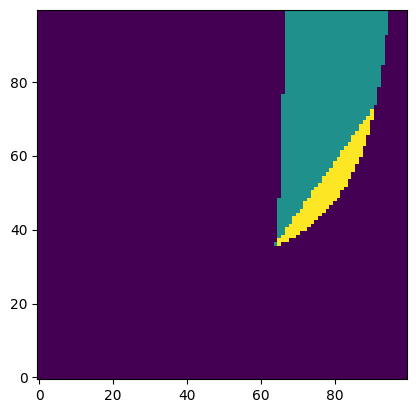

In [593]:
region_ = region.copy()
region_[p0[0], p0[1]] = 1
for i in range(200):
    region_[arr[i][0], arr[i][1]] = 2

plt.imshow(region_, origin='lower')

In [594]:
def ccw(x, y, p):
    return (x[0] - p[0]) * (y[1] - p[1]) - (x[1] - p[1]) * (y[0] - p[0])

In [595]:
def next_to_top(stack):
    return stack.pop().pop()

In [596]:
def top(stack):
    return stack.pop()

In [597]:
for point in points:
    while len(stack) > 1 and ccw(stack[-2], stack[-1], point) >= 0:
        stack.pop()
    stack.append(point)

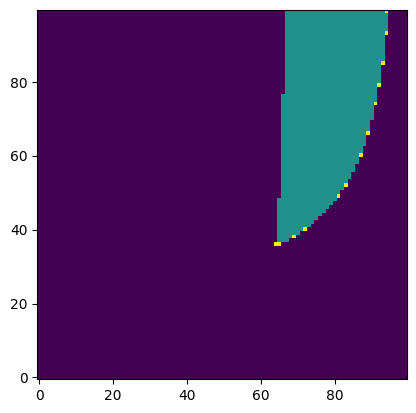

In [598]:
region_ = region.copy()
region_[p0[0], p0[1]] = 1
for i in range(len(stack)):
    region_[stack[i][0], stack[i][1]] = 2

plt.imshow(region_, origin='lower')

In [425]:
def compare(x, y):
    if (x[0] - p0[0])**2 + (x[1] - p0[1])**2 ==



    return (y[1] - p[1]) / (y[0] - p[0]) > (x[1] - p[1]) / (x[0] - p[0])

In [407]:
def comp(x):
    return x[0] + x[1]

In [409]:



sorted([
    [1, 2],
    [1, 1],
    [2, 1]
], key=cmp_to_key(compare))

[[1, 1], [1, 2], [2, 1]]

In [413]:
a = 1
b = 2
a, b = b, a

In [414]:
a


2